# COMP333 - Phase 2

This notebook contains information relating to the training of a machine learning model(s) to predict the IMDB score (out of 100) of a movie given various parameters, including cast, langauge, country of production, actor names and production company.


# Data Integration


In [ ]:
import os
import pandas as pd

# Path to the folder containing CSV files
folder_path = "../Datasets/"

# List all files in the folder
files = os.listdir(folder_path)

# Filter for CSV files
csv_files = [file for file in files if file.endswith('.csv')]

# Iterate through each CSV file
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    try:
        # Try reading the file with UTF-8 encoding
        df = pd.read_csv(file_path)
        print(f"Features of {csv_file}:")
        print(df.columns.tolist())
        print("\n")  # Add a newline for better readability
    except UnicodeDecodeError:
        try:
            # If UTF-8 fails, fall back to Latin-1
            df = pd.read_csv(file_path, encoding='latin1')
            print(f"Features of {csv_file} (read with 'latin1' encoding):")
            print(df.columns.tolist())
            print("\n")  # Add a newline for better readability
        except Exception as e:
            print(f"Could not read {csv_file} due to error: {e}")


In [ ]:
!pip install rapidfuzz pandas

import pandas as pd
from rapidfuzz import process, fuzz

df_imdb = pd.read_csv("./Datasets/imdb_movies.csv")
df_tmdb = pd.read_csv("./Datasets/TMDB_movie_dataset_v11.csv")

def preprocess_title(title):
    """Helper function to preprocess movie titles (lowercase and strip spaces)"""
    if isinstance(title, str):
        return title.lower().strip()
    else:
        return ""

def fuzzy_match_columns(df1, df2, column1, column2, threshold=90):
    # Preprocess the title columns
    df1[column1] = df1[column1].apply(preprocess_title)
    df2[column2] = df2[column2].apply(preprocess_title)
    
    matches = []
    
    # For each value in column1 of df1, find the best match in column2 of df2
    for value1 in df1[column1]:
        result = process.extractOne(value1, df2[column2], scorer=fuzz.WRatio)
        
        if result:
            best_match, similarity, _ = result  # Extract best match and its score
            if similarity >= threshold:
                # Find the row in df2 with the matching title
                matched_row = df2[df2[column2] == best_match]
                matches.append((value1, best_match, similarity, matched_row))
            else:
                matches.append((value1, None, 0, None))  # No match above threshold
        else:
            matches.append((value1, None, 0, None))  # No match found
    
    # Create a DataFrame with the matches and additional information
    match_details = []
    for match in matches:
        value1, best_match, similarity, matched_row = match
        if matched_row is not None:
            # Extract the matched row (you can specify columns to extract from df2 here)
            matched_row_data = matched_row.iloc[0]  # Assuming the first match
            match_details.append((value1, best_match, similarity, *matched_row_data))
        else:
            match_details.append((value1, best_match, similarity, None, None))  # No match
    
    # Convert the match details into a DataFrame
    match_columns = [column1, f'{column2}_matched', 'similarity'] + list(df2.columns)
    match_df = pd.DataFrame(match_details, columns=match_columns)
    
    # Merge the original df1 with the match_df on column1 to retain all rows
    merged_df = pd.merge(df1, match_df, left_on=column1, right_on=column1, how='left')
    
    return merged_df

df_imdb['names'] = df_imdb['names'].apply(preprocess_title)
df_tmdb['title'] = df_tmdb['title'].apply(preprocess_title)

df_final_1 = fuzzy_match_columns(df_imdb, df_tmdb, 'names', 'title', threshold=90)
print(df_final_1.head())



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


                         names       date_x  score  \
0                    creed iii  03/02/2023    73.0   
1     avatar: the way of water  12/15/2022    78.0   
2  the super mario bros. movie  04/05/2023    76.0   
3                      mummies  01/05/2023    70.0   
4                    supercell  03/17/2023    61.0   

                                           genre  \
0                                  Drama, Action   
1             Science Fiction, Adventure, Action   
2  Animation, Adventure, Family, Fantasy, Comedy   
3  Animation, Comedy, Family, Adventure, Fantasy   
4                                         Action   

                                          overview_x  \
0  After dominating the boxing world, Adonis Cree...   
1  Set more than a decade after the events of the...   
2  While working underground to fix a water main,...   
3  Through a series of unfortunate events, three ...   
4  Good-hearted teenager William always lived in ...   

                         

In [ ]:
print(f"Length difference percentage: {abs(len(df_final_1) - len(df_imdb)) / len(df_imdb) * 100:.2f}%")
print(df_final_1.columns)

Length difference percentage: 18.65%
Index(['names', 'date_x', 'score', 'genre', 'overview_x', 'crew', 'orig_title',
       'status_x', 'orig_lang', 'budget_x', 'revenue_x', 'country',
       'title_matched', 'similarity', 'id', 'title', 'vote_average',
       'vote_count', 'status_y', 'release_date', 'revenue_y', 'runtime',
       'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview_y', 'popularity',
       'poster_path', 'tagline', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'keywords'],
      dtype='object')


In [4]:
# Matching Country Information with each Movie

# Step 1: Load the countries.csv file
df_countries = pd.read_csv('./Datasets/countries.csv', encoding='latin1')

# Step 2: Create a country code to country name mapping
country_code_to_name = {
    'AU': 'Australia',
    'US': 'United States',
    'MX': 'Mexico',
    'GB': 'United Kingdom',
    'CL': 'Chile',
    'NO': 'Norway',
    'ES': 'Spain',
    'AR': 'Argentina',
    'KR': 'South Korea',
    'HK': 'Hong Kong',
    'UA': 'Ukraine',
    'IT': 'Italy',
    'RU': 'Russia',
    'CO': 'Colombia',
    'DE': 'Germany',
    'JP': 'Japan',
    'FR': 'France',
    'FI': 'Finland',
    'IS': 'Iceland',
    'ID': 'Indonesia',
    'BR': 'Brazil',
    'BE': 'Belgium',
    'DK': 'Denmark',
    'TR': 'Turkey',
    'TH': 'Thailand',
    'PL': 'Poland',
    'GT': 'Guatemala',
    'CN': 'China',
    'CZ': 'Czech Republic',
    'PH': 'Philippines',
    'ZA': 'South Africa',
    'CA': 'Canada',
    'NL': 'Netherlands',
    'TW': 'Taiwan',
    'PR': 'Puerto Rico',
    'IN': 'India',
    'IE': 'Ireland',
    'SG': 'Singapore',
    'PE': 'Peru',
    'CH': 'Switzerland',
    'SE': 'Sweden',
    'IL': 'Israel',
    'DO': 'Dominican Republic',
    'VN': 'Vietnam',
    'GR': 'Greece',
    'SU': 'Soviet Union',
    'HU': 'Hungary',
    'BO': 'Bolivia',
    'SK': 'Slovakia',
    'UY': 'Uruguay',
    'BY': 'Belarus',
    'AT': 'Austria',
    'PY': 'Paraguay',
    'MY': 'Malaysia',
    'MU': 'Mauritius',
    'LV': 'Latvia',
    'XC': 'Cross-Country',
    'PT': 'Portugal',
    'KH': 'Cambodia',
    'IR': 'Iran'
}

# Step 3: Map the 'country' column in df_final to full names using the dictionary
df_final_1['full_country_name'] = df_final_1['country'].map(country_code_to_name)

# Step 5: Now, proceed with your merging process
# First, we ensure df_countries has the right 'Country' column format
df_countries['Country'] = df_countries['Country'].str.strip().str.title()

# Step 6: Append the word 'Country' to the headers (not the country name)
df_countries_renamed = df_countries.rename(columns=lambda col: f"Country_{col}" if col != 'Country' else col)

# Step 7: Merge the full country names with df_countries
df_final_2 = pd.merge(
    df_final_1,
    df_countries_renamed,
    left_on='full_country_name',  # Merge using the full country names
    right_on='Country',  # Ensure 'Country' is the correct column in df_countries
    how='left'  # Use left join to preserve all rows in df_final
)

print(df_final_2.head())

                         names       date_x  score  \
0                    creed iii  03/02/2023    73.0   
1     avatar: the way of water  12/15/2022    78.0   
2  the super mario bros. movie  04/05/2023    76.0   
3                      mummies  01/05/2023    70.0   
4                    supercell  03/17/2023    61.0   

                                           genre  \
0                                  Drama, Action   
1             Science Fiction, Adventure, Action   
2  Animation, Adventure, Family, Fantasy, Comedy   
3  Animation, Comedy, Family, Adventure, Fantasy   
4                                         Action   

                                          overview_x  \
0  After dominating the boxing world, Adonis Cree...   
1  Set more than a decade after the events of the...   
2  While working underground to fix a water main,...   
3  Through a series of unfortunate events, three ...   
4  Good-hearted teenager William always lived in ...   

                         

In [5]:
# Analyzing missing country data movies

# Step 2: Count how many rows are matched and unmatched
matched_rows = df_final_2['Country'].notna().sum()  # Rows where the 'Country' column is not null (i.e., matched)
unmatched_rows = df_final_2['Country'].isna().sum()  # Rows where the 'Country' column is null (i.e., unmatched)

# Step 3: Calculate the percentages
total_rows = len(df_final_2)
matched_percentage = (matched_rows / total_rows) * 100
unmatched_percentage = (unmatched_rows / total_rows) * 100

# Step 4: Print the results
print(f"Matched Rows: {matched_rows} ({matched_percentage:.2f}%)")
print(f"Unmatched Rows: {unmatched_rows} ({unmatched_percentage:.2f}%)")

Matched Rows: 11939 (98.87%)
Unmatched Rows: 137 (1.13%)


In [6]:
# Integrating highest grossing boolean feature from time_metrics.csv

# Step 1: Load your merged DataFrame and the time_metrics.csv dataset
df_time_metrics = pd.read_csv('./Datasets/time_metrics.csv', encoding='latin1')

# Step 2: Preprocess the movie titles in both datasets
df_final_2['processed_name'] = df_final_2['names'].apply(preprocess_title)
df_time_metrics['processed_release'] = df_time_metrics['#1 Release'].apply(preprocess_title)

# Step 3: Define a function to calculate the WRatio similarity
def is_top_grossing(movie_title, release_titles, threshold=90):
    # Compare the movie title to each of the releases in time_metrics
    for release in release_titles:
        similarity = fuzz.WRatio(movie_title, release)
        if similarity >= threshold:
            return True  # Return True if a similar title is found
    return False  # Return False if no similar title is found

df_final_3 = df_final_2

# Step 4: Apply the function to create the "TopGrossingOfMonth" column
release_titles = df_time_metrics['processed_release'].tolist()  # List of movie titles from time_metrics
df_final_3['TopGrossingOfMonth'] = df_final_3['processed_name'].apply(lambda x: is_top_grossing(x, release_titles))

# Step 5: Check the results
print(df_final_3.head())

                         names       date_x  score  \
0                    creed iii  03/02/2023    73.0   
1     avatar: the way of water  12/15/2022    78.0   
2  the super mario bros. movie  04/05/2023    76.0   
3                      mummies  01/05/2023    70.0   
4                    supercell  03/17/2023    61.0   

                                           genre  \
0                                  Drama, Action   
1             Science Fiction, Adventure, Action   
2  Animation, Adventure, Family, Fantasy, Comedy   
3  Animation, Comedy, Family, Adventure, Fantasy   
4                                         Action   

                                          overview_x  \
0  After dominating the boxing world, Adonis Cree...   
1  Set more than a decade after the events of the...   
2  While working underground to fix a water main,...   
3  Through a series of unfortunate events, three ...   
4  Good-hearted teenager William always lived in ...   

                         

In [7]:
# Analyzing the results of merging new grossing feature

print(df_final_3['TopGrossingOfMonth'].value_counts(), "\nPercentage:\n", df_final_3['TopGrossingOfMonth'].value_counts(normalize=True) * 100)

TopGrossingOfMonth
False    9633
True     2443
Name: count, dtype: int64 
Percentage:
 TopGrossingOfMonth
False    79.769791
True     20.230209
Name: proportion, dtype: float64


In [8]:
# Integrating Production Companies Profits from productions_companies_wiki_searches into main df

# We first split the production_companies feature into its own columns

# Step 1: Split 'production_companies' by commas into a list
df_final_3['production_companies_split'] = df_final_3['production_companies'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Step 2: Create new columns for the first two production companies (production_company_1 and production_company_2)
df_final_3['production_company_1'] = df_final_3['production_companies_split'].apply(lambda x: x[0] if len(x) > 0 else None)
df_final_3['production_company_2'] = df_final_3['production_companies_split'].apply(lambda x: x[1] if len(x) > 1 else None)

# Step 3: Drop the temporary 'production_companies_split' column
df_final_3.drop(columns=['production_companies_split'], inplace=True)

# Display the resulting DataFrame
print(df_final_3.head())

                         names       date_x  score  \
0                    creed iii  03/02/2023    73.0   
1     avatar: the way of water  12/15/2022    78.0   
2  the super mario bros. movie  04/05/2023    76.0   
3                      mummies  01/05/2023    70.0   
4                    supercell  03/17/2023    61.0   

                                           genre  \
0                                  Drama, Action   
1             Science Fiction, Adventure, Action   
2  Animation, Adventure, Family, Fantasy, Comedy   
3  Animation, Comedy, Family, Adventure, Fantasy   
4                                         Action   

                                          overview_x  \
0  After dominating the boxing world, Adonis Cree...   
1  Set more than a decade after the events of the...   
2  While working underground to fix a water main,...   
3  Through a series of unfortunate events, three ...   
4  Good-hearted teenager William always lived in ...   

                         

In [9]:
# Step 1: Load the production_companies.csv dataset
df_production_companies_profits = pd.read_csv('./Datasets/production_companies.csv', encoding='latin1')

# Step 2: Preprocess the production companies in both datasets
def preprocess_title(title):
    return title.lower().strip() if isinstance(title, str) else ""

df_final_3['production_company_1_processed'] = df_final_3['production_company_1'].apply(preprocess_title)
df_final_3['production_company_2_processed'] = df_final_3['production_company_2'].apply(preprocess_title)
df_production_companies_profits['processed_company'] = df_production_companies_profits['Production Companies'].apply(preprocess_title)

# Step 3: Define a function for fuzzy matching with a threshold
def fuzzy_match(production_company, company_list, threshold=90):
    match = process.extractOne(production_company, company_list, scorer=fuzz.WRatio)
    if match and match[1] >= threshold:
        return match[0], match[1]  # Return the best match and similarity score
    return None, None  # No match if similarity is below the threshold

# Step 4: Apply the fuzzy match function to both columns and store results
production_companies_list = df_production_companies_profits['processed_company'].tolist()

# For production_company_1
df_final_3['matched_production_company_1'], df_final_3['similarity_1'] = zip(
    *df_final_3['production_company_1_processed'].apply(lambda x: fuzzy_match(x, production_companies_list))
)

# For production_company_2
df_final_3['matched_production_company_2'], df_final_3['similarity_2'] = zip(
    *df_final_3['production_company_2_processed'].apply(lambda x: fuzzy_match(x, production_companies_list))
)

# Step 5: Merge the matched results with df_production_companies

# Add suffix for production_company_1 columns before the first merge
df_production_companies_1 = df_production_companies_profits.add_suffix('_company_1')
df_final_4 = pd.merge(df_final_3, 
                      df_production_companies_1, 
                      left_on='matched_production_company_1', 
                      right_on='processed_company_company_1', 
                      how='left')

# Add suffix for production_company_2 columns before the second merge
df_production_companies_2 = df_production_companies_profits.add_suffix('_company_2')
df_final_4 = pd.merge(df_final_4, 
                      df_production_companies_2, 
                      left_on='matched_production_company_2', 
                      right_on='processed_company_company_2', 
                      how='left')

In [10]:
# Drop temporary columns used for matching
df_final_4.drop(columns=['similarity_1', 'processed_name',
        'similarity_2', 'processed_company_company_1', 
       'Production Companies_company_1', 'Production Companies_company_2', 
       'processed_company_company_2'], inplace=True)


In [11]:
# Step 7: Display the final DataFrame
# List of columns to check for null values
columns_to_check = [
    'production_company_1', 'production_company_2',
    'No. of Movies_company_1', 'Total Domestic Box Office($)_company_1',
    'Total Worldwide Box Office($)_company_1', 
    'No. of Movies_company_2', 'Total Domestic Box Office($)_company_2',
    'Total Worldwide Box Office($)_company_2'
]

# Count the number of null values in the selected columns
null_count = df_final_4[columns_to_check].isnull().sum()

# Calculate the percentage of null values for each column
null_percentage = (df_final_4[columns_to_check].isnull().sum() / len(df_final_4)) * 100

# Display the results
print("Null Count:")
print(null_count)

print("\nNull Percentage:")
print(df_final_4[df_final_4['production_company_1'].isnull()].head(5))


Null Count:
production_company_1                        507
production_company_2                       2848
No. of Movies_company_1                    2475
Total Domestic Box Office($)_company_1     2475
Total Worldwide Box Office($)_company_1    2475
No. of Movies_company_2                    4227
Total Domestic Box Office($)_company_2     4227
Total Worldwide Box Office($)_company_2    4227
dtype: int64

Null Percentage:
                                                 names       date_x  score  \
17               prizefighter: the life of jem belcher  07/22/2022    62.0   
155                          prancer: a christmas tale  11/22/2022    59.0   
158                                 the penitent thief  02/25/2021    62.0   
248  legend of the galactic heroes: die neue these ...  09/30/2022    61.0   
328                                       el tirabeque  11/25/2022    30.0   

               genre                                         overview_x  \
17    Drama, History  At the 

In [12]:
# Integrating production_companies_wiki_searches.csv into the main dataframe

# Step 1: Load the production_companies.csv dataset
df_production_companies_wiki = pd.read_csv('./Datasets/production_companies_wiki_searches.csv', encoding='latin1')

## Convert the 'Timestamp' to a datetime object to extract the year
df_production_companies_wiki['Timestamp'] = pd.to_datetime(df_production_companies_wiki['Timestamp'])
df_production_companies_wiki['Year'] = df_production_companies_wiki['Timestamp'].dt.year

# Filter the data to include only records from 2015 to 2024
df_wiki_filtered = df_production_companies_wiki[(df_production_companies_wiki['Year'] >= 2015) & (df_production_companies_wiki['Year'] <= 2024)]

# Aggregate the views by Production Company over the years 2015 to 2024
df_wiki_aggregated = df_wiki_filtered.groupby('Production Company').agg({
    'Views': 'sum'
}).reset_index()


# Display the aggregated data
print(df_wiki_aggregated.head())

                    Production Company    Views
0      "DIA" Productions GmbH & Co. KG   155242
1  "Weathering With You" Film Partners  5868307
2             "Yeni Film" Film Company     8855
3                  (Colossal) Pictures   122652
4            1 Production Film Company  1765967


In [14]:
df_wiki_aggregated['processed_company'] = df_wiki_aggregated['Production Company'].apply(preprocess_title)

# Step 4: Apply the fuzzy match function to both columns and store results
df_wiki_aggregated_list = df_wiki_aggregated['processed_company'].tolist()

# For production_company_1
df_final_4['matched_production_company_1'], df_final_4['similarity_1'] = zip(
    *df_final_4['production_company_1_processed'].apply(lambda x: fuzzy_match(x, df_wiki_aggregated_list))
)

# For production_company_2
df_final_4['matched_production_company_2'], df_final_4['similarity_2'] = zip(
    *df_final_4['production_company_2_processed'].apply(lambda x: fuzzy_match(x, df_wiki_aggregated_list))
)

# Step 6: Merge aggregated Wiki search counts into df_final_3 for production_company_1
df_wiki_aggregated_1 = df_wiki_aggregated.add_suffix('_company_1')
df_final_5 = pd.merge(df_final_4, df_wiki_aggregated_1[['processed_company_company_1', 'Views_company_1']],
                      left_on='matched_production_company_1', 
                      right_on='processed_company_company_1', 
                      how='left')

# Merge aggregated Wiki search counts into df_final_3 for production_company_2
df_wiki_aggregated_2 = df_wiki_aggregated.add_suffix('_company_2')
df_final_5 = pd.merge(df_final_5, df_wiki_aggregated_2[['processed_company_company_2', 'Views_company_2']],
                      left_on='matched_production_company_2', 
                      right_on='processed_company_company_2', 
                      how='left')

In [ ]:
# Drop temporary columns used for matching
df_final_5.drop(columns=['matched_production_company_1', 'matched_production_company_2',
                         'similarity_1', 'similarity_2', 'processed_company_company_1',
                        'processed_company_company_2', 'production_company_2_processed', 'production_company_1_processed'], inplace=True)

print(df_final_5.columns)

Index(['names', 'date_x', 'score', 'genre', 'overview_x', 'crew', 'orig_title',
       'status_x', 'orig_lang', 'budget_x', 'revenue_x', 'country',
       'title_matched', 'similarity', 'id', 'title', 'vote_average',
       'vote_count', 'status_y', 'release_date', 'revenue_y', 'runtime',
       'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview_y', 'popularity',
       'poster_path', 'tagline', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'keywords',
       'full_country_name', 'Country', 'Country_GDP Per Capita',
       'Country_Population', 'Country_Box Office Admission',
       'Country_Box Office Revenues', 'TopGrossingOfMonth',
       'production_company_1', 'production_company_2',
       'No. of Movies_company_1', 'Total Domestic Box Office($)_company_1',
       'Total Worldwide Box Office($)_company_1', 'No. of Movies_company_2',
       'Total Domestic Box Office($)_company_2

In [20]:
# Integrating crew_wiki_searches.csv into the main dataframe

# Define a function to extract specific actors from the crew column
def extract_actors(crew):
    # Split the crew string by comma
    crew_list = [name.strip() for name in crew.split(',')] if isinstance(crew, str) else []
    # Extract the 1st, 3rd, and 5th actors if they exist, otherwise use None
    actor_1 = crew_list[0] if len(crew_list) > 0 else None
    actor_3 = crew_list[2] if len(crew_list) > 2 else None
    actor_5 = crew_list[4] if len(crew_list) > 4 else None
    return actor_1, actor_3, actor_5

# Apply the function to the dataset and create new columns
df_final_5[['actor_1', 'actor_3', 'actor_5']] = df_final_5['crew'].apply(
    lambda x: pd.Series(extract_actors(x))
)

# Check the resulting DataFrame
print(df_final_5[['actor_1', 'actor_3', 'actor_5']].head())

             actor_1            actor_3           actor_5
0  Michael B. Jordan     Tessa Thompson   Jonathan Majors
1    Sam Worthington        Zoe Saldaña  Sigourney Weaver
2        Chris Pratt    Anya Taylor-Joy       Charlie Day
3     Óscar Barberán  Ana Esther Alborg  Luis Pérez Reina
4       Skeet Ulrich         Anne Heche     Daniel Diemer


In [ ]:
# Checking movies where crew is not defined

# Filter rows where actor_1 is null
movies_without_actor_1 = df_final_5[df_final_5['actor_1'].isnull()]

# Display these movies
print("Movies without actor_1:")
print(movies_without_actor_1[['title', 'actor_1']])  # Assuming 'title' is the column for movie names

# Count the number of such movies
print(f"Number of movies without actor_1: {len(movies_without_actor_1)}")


Movies without actor_1:
                                                   title actor_1
182                    orgasm inc: the story of onetaste    None
248    legend of the galactic heroes: die neue these ...    None
861                    cuento de primavera-a spring tale    None
1271              cat pack: a paw patrol exclusive event    None
2051                                             reclaim    None
2283                        avatar: scene deconstruction    None
2365             cyber hell: exposing an internet horror    None
2424                      guinea pig: devil's experiment    None
2641                                               moses    None
3175                                              barbie    None
3176                                              barbie    None
3429                                              naruto    None
3666                                   far from the tree    None
3857                                ki mein jhoot boleya    None
3

In [23]:
# Aggregating the crew_wiki_searches dataset

# Step 1: Load the crew_wiki_searches.csv dataset
df_crew_wiki = pd.read_csv('./Datasets/crew_wiki_searches.csv', encoding='latin1')

## Convert the 'Timestamp' to a datetime object to extract the year
df_crew_wiki['Timestamp'] = pd.to_datetime(df_crew_wiki['Timestamp'])
df_crew_wiki['Year'] = df_crew_wiki['Timestamp'].dt.year

# Filter the data to include only records from 2015 to 2024
df_crew_wiki_filtered = df_crew_wiki[(df_crew_wiki['Year'] >= 2015) & (df_crew_wiki['Year'] <= 2024)]

# Aggregate the views by Production Company over the years 2015 to 2024
df_crew_wiki_aggregated = df_crew_wiki_filtered.groupby('Crew').agg({
    'Views': 'sum'
}).reset_index()


# Display the aggregated data
print(df_crew_wiki_aggregated.head())

                  Crew     Views
0            'Pierrot'   2134622
1  'Weird Al' Yankovic  17662632
2         14 Years Old   2484912
3              50 Cent  29555558
4            A.J. Cook   6404240


In [28]:
df_crew_wiki_aggregated['processed_crew_name'] = df_crew_wiki_aggregated['Crew'].apply(preprocess_title)

# Step 4: Apply the fuzzy match function to both columns and store results
df_crew_wiki_aggregated_list = df_crew_wiki_aggregated['processed_crew_name'].tolist()

df_final_5['processed_actor_1'] = df_final_5['actor_1'].apply(preprocess_title)
df_final_5['processed_actor_3'] = df_final_5['actor_3'].apply(preprocess_title)
df_final_5['processed_actor_5'] = df_final_5['actor_5'].apply(preprocess_title)

# For actor_1
df_final_5['matched_actor_name_1'], df_final_5['similarity_1'] = zip(
    *df_final_5['processed_actor_1'].apply(lambda x: fuzzy_match(x, df_crew_wiki_aggregated_list))
)

# For actor_3
df_final_5['matched_actor_name_3'], df_final_5['similarity_2'] = zip(
    *df_final_5['processed_actor_3'].apply(lambda x: fuzzy_match(x, df_crew_wiki_aggregated_list))
)

# For actor_5
df_final_5['matched_actor_name_5'], df_final_5['similarity_3'] = zip(
    *df_final_5['processed_actor_5'].apply(lambda x: fuzzy_match(x, df_crew_wiki_aggregated_list))
)

# Step 6: merging actor_1
df_wiki_aggregated_1 = df_crew_wiki_aggregated.add_suffix('_actor_1')
df_final_6 = pd.merge(df_final_5, df_wiki_aggregated_1[['processed_crew_name_actor_1', 'Views_actor_1']],
                      left_on='matched_actor_name_1', 
                      right_on='processed_crew_name_actor_1', 
                      how='left')

# merging actor_3
df_wiki_aggregated_3 = df_crew_wiki_aggregated.add_suffix('_actor_3')
df_final_6 = pd.merge(df_final_6, df_wiki_aggregated_3[['processed_crew_name_actor_3', 'Views_actor_3']],
                      left_on='matched_actor_name_3', 
                      right_on='processed_crew_name_actor_3', 
                      how='left')

# merging actor_5
df_wiki_aggregated_5 = df_crew_wiki_aggregated.add_suffix('_actor_5')
df_final_6 = pd.merge(df_final_6, df_wiki_aggregated_5[['processed_crew_name_actor_5', 'Views_actor_5']],
                      left_on='matched_actor_name_5', 
                      right_on='processed_crew_name_actor_5', 
                      how='left')

In [31]:
# Drop temporary columns used for matching
df_final_6.drop(columns=['processed_crew_name_actor_1', 'processed_crew_name_actor_3', 'processed_crew_name_actor_5',
                         'similarity_1', 'similarity_2', 'similarity_3', 'title_matched', 'similarity', 
                         'matched_actor_name_1', 'matched_actor_name_3', 'matched_actor_name_5',
                         'processed_actor_1', 'processed_actor_3', 'processed_actor_5'
                         ], inplace=True)

print(df_final_6.columns)

Index(['names', 'date_x', 'score', 'genre', 'overview_x', 'crew', 'orig_title',
       'status_x', 'orig_lang', 'budget_x', 'revenue_x', 'country', 'id',
       'title', 'vote_average', 'vote_count', 'status_y', 'release_date',
       'revenue_y', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview_y',
       'popularity', 'poster_path', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'keywords', 'full_country_name', 'Country', 'Country_GDP Per Capita',
       'Country_Population', 'Country_Box Office Admission',
       'Country_Box Office Revenues', 'TopGrossingOfMonth',
       'production_company_1', 'production_company_2',
       'No. of Movies_company_1', 'Total Domestic Box Office($)_company_1',
       'Total Worldwide Box Office($)_company_1', 'No. of Movies_company_2',
       'Total Domestic Box Office($)_company_2',
       'Total Worldwide Box Office(

In [32]:
# Checking how many actor views are null

# Check null values for each column
null_counts = {
    'Views_actor_1': df_final_6['Views_actor_1'].isnull().sum(),
    'Views_actor_3': df_final_6['Views_actor_3'].isnull().sum(),
    'Views_actor_5': df_final_6['Views_actor_5'].isnull().sum()
}

# Display the counts
for column, count in null_counts.items():
    print(f"{column}: {count} null values")


Views_actor_1: 405 null values
Views_actor_3: 543 null values
Views_actor_5: 694 null values


# Data Cleaning


In [37]:
df_final_6.isnull().sum()

names                                         0
date_x                                        0
score                                         0
genre                                        91
overview_x                                    0
crew                                         60
orig_title                                    0
status_x                                      0
orig_lang                                     0
budget_x                                      0
revenue_x                                     0
country                                       0
id                                            6
title                                         6
vote_average                                  6
vote_count                                    6
status_y                                      6
release_date                                 16
revenue_y                                     6
runtime                                       6
adult                                   

In [70]:
columns_to_drop = ['crew', 'id', 'title', 'release_date', 'revenue_y', 'backdrop_path', 'homepage', 'imdb_id', 
                   'original_language', 'original_title', 'overview_y', 'popularity', 'poster_path', 
                   'production_countries', 'spoken_languages', 'keywords', 'budget', 'tagline', 'full_country_name', 'orig_title', 'adult']

# Drop the columns
df_final_7 = df_final_6.drop(columns=columns_to_drop)

# Confirm changes
print(df_final_7.isnull().sum())


names                                         0
date_x                                        0
score                                         0
genre                                        91
overview_x                                    0
status_x                                      0
orig_lang                                     0
budget_x                                      0
revenue_x                                     0
country                                       0
vote_average                                  6
vote_count                                    6
status_y                                      6
runtime                                       6
genres                                       70
production_companies                        507
Country                                     137
Country_GDP Per Capita                      137
Country_Population                          137
Country_Box Office Admission                155
Country_Box Office Revenues             

In [71]:
df_final_8 = df_final_7.dropna(axis = 0, subset = ['genres', 'production_companies', 'Country', 'Country_GDP Per Capita', 'Country_Population', 'Country_Box Office Admission',
                                                   'Country_Box Office Revenues', 'production_company_1', 'production_company_2', 'Views_company_1', 'Views_company_2',
                                                   'actor_1', 'actor_3', 'actor_5', 'Views_actor_1', 'Views_actor_3', 'Views_actor_5', 'No. of Movies_company_1', 'No. of Movies_company_2'])

print(df_final_8.isnull().sum())

print(len(df_final_8))

names                                      0
date_x                                     0
score                                      0
genre                                      3
overview_x                                 0
status_x                                   0
orig_lang                                  0
budget_x                                   0
revenue_x                                  0
country                                    0
vote_average                               0
vote_count                                 0
status_y                                   0
runtime                                    0
genres                                     0
production_companies                       0
Country                                    0
Country_GDP Per Capita                     0
Country_Population                         0
Country_Box Office Admission               0
Country_Box Office Revenues                0
TopGrossingOfMonth                         0
production

In [72]:
df_final_9 = df_final_8.drop_duplicates(subset='names', keep='first')

print(len(df_final_9))

4775


In [75]:
# Count how many 0's are in each column
zero_counts = (df_final_9 == 0).sum()
print(zero_counts)


names                                         0
date_x                                        0
score                                        54
genre                                         0
overview_x                                    0
status_x                                      0
orig_lang                                     0
budget_x                                      0
revenue_x                                    30
country                                       0
vote_average                                  3
vote_count                                    3
status_y                                      0
runtime                                       3
genres                                        0
production_companies                          0
Country                                       0
Country_GDP Per Capita                        0
Country_Population                            0
Country_Box Office Admission                  0
Country_Box Office Revenues             

In [ ]:
!pip install matplotlib
!pip install seaborn

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

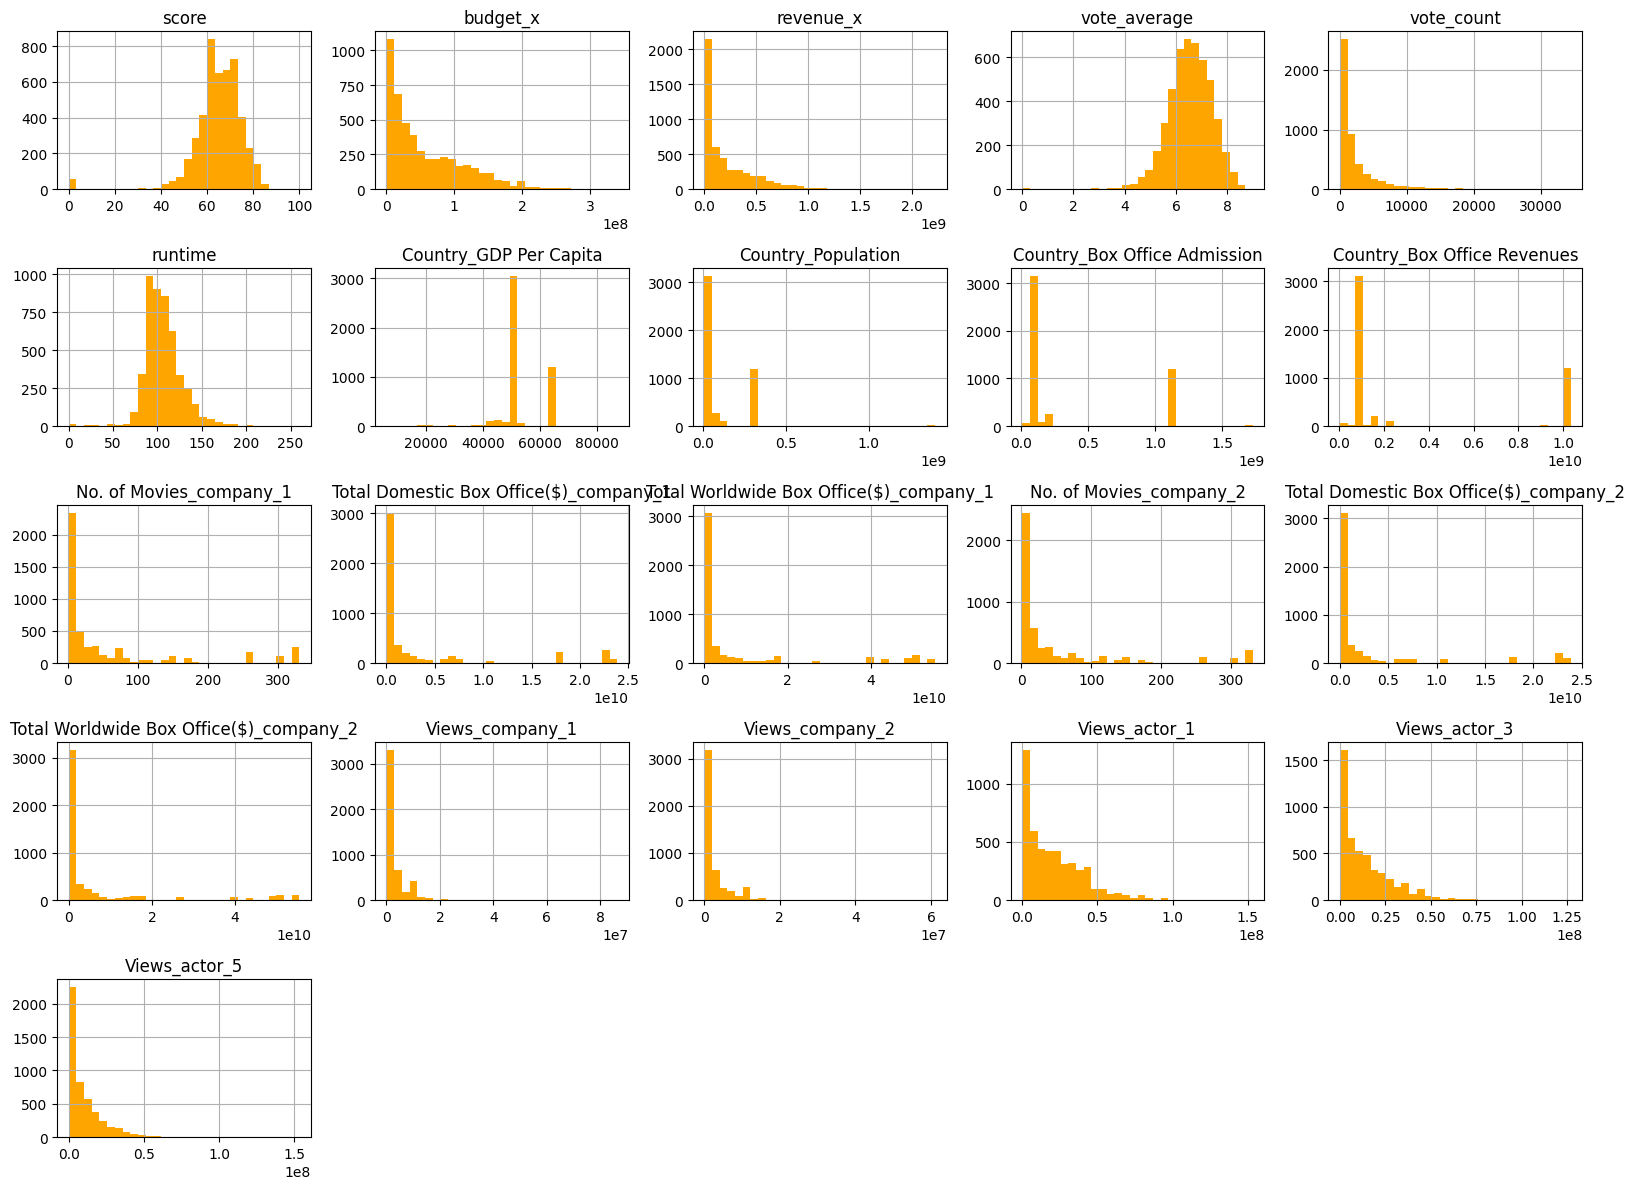

In [83]:
# Create the histogram
df_final_9.hist(bins=30, figsize=(16, 12), color='Orange', xlabelsize=10, ylabelsize=10)

# Add gridlines for better visualization
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

# Add axis labels with more description
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Set title for the plot
plt.title('Distribution of Values in df_final_9', fontsize=14)

# Set tick parameters for axis labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


<Axes: >

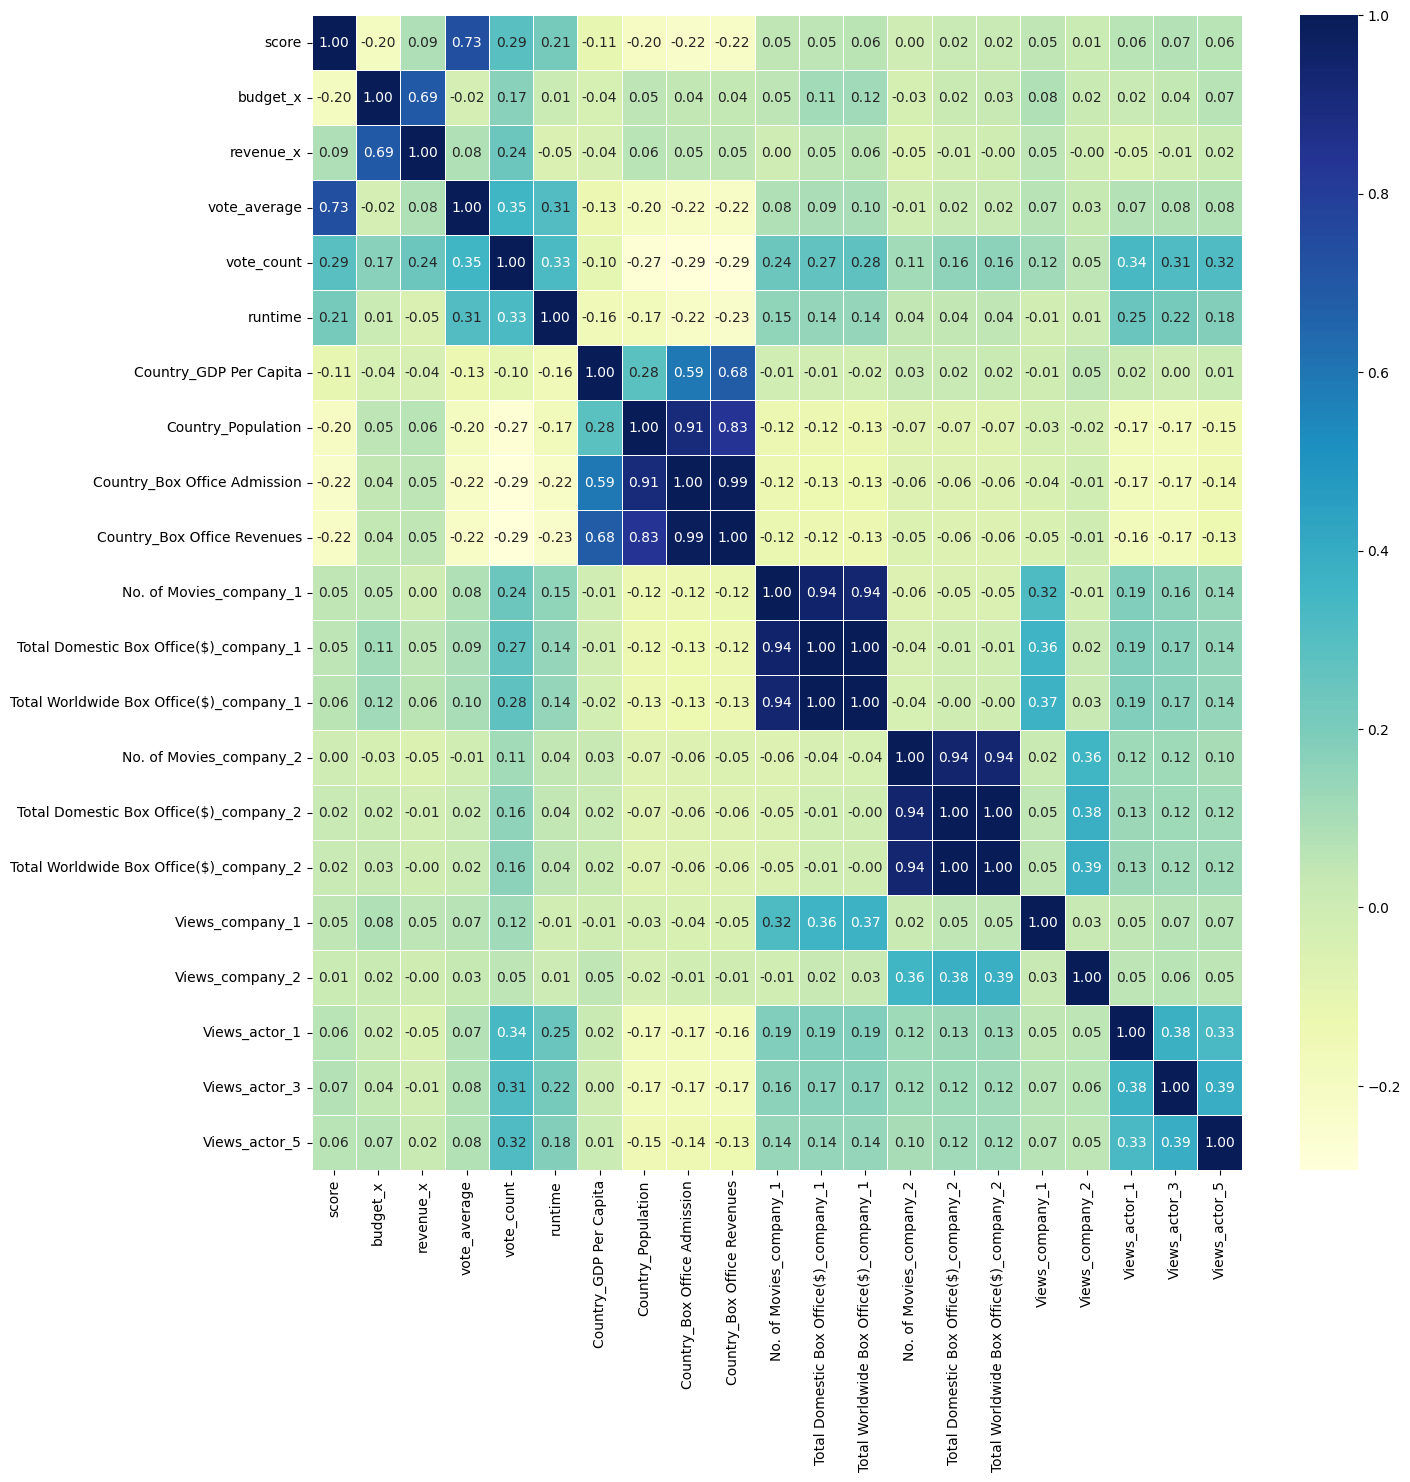

In [84]:
# Select only the numeric columns from the DataFrame
numeric_df = df_final_9.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation = numeric_df.corr()

# Plot the heatmap
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation, annot=True, cmap="YlGnBu", linewidths=.5, fmt='.2f')


# Data Transformation


In [76]:
df_final_9.describe()

,score,budget_x,revenue_x,vote_average,vote_count,runtime,Country_GDP Per Capita,Country_Population,Country_Box Office Admission,Country_Box Office Revenues,...,Total Domestic Box Office($)_company_1,Total Worldwide Box Office($)_company_1,No. of Movies_company_2,Total Domestic Box Office($)_company_2,Total Worldwide Box Office($)_company_2,Views_company_1,Views_company_2,Views_actor_1,Views_actor_3,Views_actor_5
count,4775.000000,4.775000e+03,4.775000e+03,4775.000000,4775.000000,4775.000000,4775.000000,4.775000e+03,4.775000e+03,4.775000e+03,...,4.775000e+03,4.775000e+03,4775.000000,4.775000e+03,4.775000e+03,4.775000e+03,4.775000e+03,4.775000e+03,4.775000e+03,4.775000e+03
mean,64.797068,5.715853e+07,2.072500e+08,6.541882,2237.340314,106.080209,53605.896335,1.146403e+08,3.640925e+08,3.326662e+09,...,3.455866e+09,7.903081e+09,50.956649,2.913816e+09,6.690965e+09,3.033596e+06,2.673807e+06,2.072944e+07,1.384617e+07,1.015049e+07
std,10.786522,5.428288e+07,2.519729e+08,0.836493,3307.549653,21.245775,7430.401743,1.610976e+08,4.593382e+08,4.101604e+09,...,6.800445e+09,1.549286e+10,86.919272,6.232918e+09,1.425225e+10,5.163372e+06,4.521293e+06,1.930684e+07,1.458438e+07,1.238787e+07
min,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,6283.000000,4.977400e+06,6.500000e+06,4.170000e+07,...,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,1.130000e+02,4.900000e+01,4.430000e+02,4.770000e+02,4.430000e+02
25%,60.000000,1.300000e+07,2.374223e+07,6.018000,360.500000,93.000000,51885.000000,2.569560e+07,8.470000e+07,8.544000e+08,...,3.113835e+06,1.770115e+07,3.000000,4.209826e+06,1.802802e+07,2.563945e+05,2.457620e+05,4.396762e+06,2.316778e+06,1.309876e+06
50%,66.000000,3.800000e+07,9.614769e+07,6.565000,1034.000000,103.000000,51885.000000,2.569560e+07,8.470000e+07,8.544000e+08,...,1.739005e+08,4.580166e+08,11.000000,1.646162e+08,3.708636e+08,9.015560e+05,8.152950e+05,1.619954e+07,9.377215e+06,5.842919e+06
75%,71.000000,9.197000e+07,3.218608e+08,7.132000,2631.500000,117.000000,63051.000000,3.282395e+08,1.128500e+09,1.033710e+10,...,2.311618e+09,5.255572e+09,49.000000,1.744864e+09,4.050206e+09,3.801516e+06,3.208203e+06,3.270616e+07,2.082951e+07,1.441715e+07
max,100.000000,3.400000e+08,2.222986e+09,8.993000,34495.000000,260.000000,86988.000000,1.400050e+09,1.730000e+09,1.033710e+10,...,2.386787e+10,5.544734e+10,331.000000,2.386787e+10,5.544734e+10,8.636401e+07,6.110010e+07,1.533727e+08,1.269076e+08,1.533727e+08


# Model Training


In [86]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Step 1: Prepare your data (assuming 'df_final_9' has no categorical columns or missing values)
# Define the features (X) and the target variable (y)
X = df_final_9.drop(columns=['score'])  # Replace 'target_column' with the actual target column name
y = df_final_9['score']  # Replace 'target_column' with the actual target column name

# Step 2: Handle categorical variables
# Identify categorical columns (if any) and apply LabelEncoding or OneHotEncoding
categorical_columns = X.select_dtypes(include=['object']).columns  # Find categorical columns in features
label_encoder = LabelEncoder()

# Apply label encoding for categorical columns
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col].astype(str))

# Step 3: Handle missing values
# Use SimpleImputer to fill missing values (mean for numerical columns)
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)  # Impute missing values in features

# If your target column (y) has missing values, impute them as well
y = imputer.fit_transform(y.values.reshape(-1, 1))  # Impute missing values in target

# Step 4: Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Initialize the regression models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor()
}

# Dictionary to store model performance
model_performance = {}

# Step 6: Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate R-squared and Mean Absolute Error
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    # Store the results
    model_performance[model_name] = {
        'R-squared': r2,
        'Mean Absolute Error': mae,
        'Root Mean Squared Error': rmse
    }

# Step 7: Display the model performance
import pandas as pd

model_performance_df = pd.DataFrame(model_performance).T
print(model_performance_df)


c:\Users\Nirav\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Nirav\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


                             R-squared  Mean Absolute Error  \
Linear Regression             0.851204             1.818830   
Random Forest Regressor       0.896247             1.080628   
Gradient Boosting Regressor   0.911067             1.135087   

                             Root Mean Squared Error  
Linear Regression                           4.246204  
Random Forest Regressor                     3.545728  
Gradient Boosting Regressor                 3.282738  


## Model Performance Summary

The output below represents the performance metrics for three regression models applied to the dataset: **Linear Regression**, **Random Forest Regressor**, and **Gradient Boosting Regressor**. The evaluation metrics are **R-squared** and **Mean Absolute Error (MAE)**.

### R-squared (R²):

- **R-squared** measures how well the model's predictions match the actual values and how much variance in the target variable is explained by the model.
  - A value closer to **1** means the model explains most of the variance.
  - A value closer to **0** means the model does not explain much of the variance.

For each model:

- **Linear Regression**: **0.8512** — Explains **85.12%** of the variance in the target variable.
- **Random Forest Regressor**: **0.8936** — Explains **89.36%** of the variance, a better fit than Linear Regression.
- **Gradient Boosting Regressor**: **0.9114** — Explains **91.14%** of the variance, the best model for explaining the variance.

### Mean Absolute Error (MAE):

- **MAE** measures the average magnitude of the errors in a set of predictions, without considering their direction.
  - A lower **MAE** indicates more accurate predictions.
  - A higher **MAE** means that the model makes larger errors.

For each model:

- **Linear Regression**: **1.8188** — On average, predictions are off by **1.82 units**.
- **Random Forest Regressor**: **1.0979** — Predictions are off by **1.0979 units**, better than Linear Regression.
- **Gradient Boosting Regressor**: **1.1292** — Predictions are off by **1.1292 units**, slightly worse than Random Forest but still better than Linear Regression.

### Summary:

- **Best Performing Model (R-squared)**: **Gradient Boosting Regressor** with the highest **R-squared** (**0.9114**).
- **Best Performing Model (MAE)**: **Random Forest Regressor** with the lowest **MAE** (**1.0979**).

In conclusion, **Gradient Boosting Regressor** is the best at explaining the variance in the target variable, while **Random Forest Regressor** offers the most accurate predictions. The choice of the final model depends on whether you prioritize predictive power or accuracy of predictions.
